# Univariate Anomaly Analysis in ECG Time-Series Using LSTM AutoEncoders

In [ ]:
!nvidia-smi

Sun Sep  1 17:18:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!unzip -qq ECG5000.zip

The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) comprises 5,000 time series samples, each captured via ECG, with a length of 140 timesteps. Each sequence represents a single heartbeat from a patient suffering from congestive heart failure.

> An electrocardiogram (ECG or EKG) is a diagnostic test that evaluates heart function by recording the electrical activity of the heart. Each heartbeat generates an electrical impulse or wave that causes the heart muscle to contract and pump blood. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

The dataset includes five types of heartbeats (classes):

- Normal (N)
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB)
- Unclassified Beat (UB)

> A healthy heart typically beats at a rate of 70 to 75 beats per minute, with each heartbeat taking approximately 0.8 seconds to complete. The normal frequency is 60–100 beats per minute, and each heartbeat lasts about 0.6–1 second. [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

In [ ]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from scipy.io import arff


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_arff_to_df(file_path):
    with open(file_path, 'r') as f:
        data, meta = arff.loadarff(f)
    return pd.DataFrame(data)

def convert_byte_strings(df, target_column):
    df[target_column] = df[target_column].apply(
        lambda x: int(x.decode('utf-8')) if isinstance(x, bytes) else int(x)
    )
    return df

train = load_arff_to_df('ECG5000_TRAIN.arff')
test = load_arff_to_df('ECG5000_TEST.arff')

target_column_name = 'target'
train = convert_byte_strings(train, target_column_name)
test = convert_byte_strings(test, target_column_name)


In [ ]:
train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [ ]:
df = pd.concat([train, test])
df = df.sample(frac=1.0).reset_index(drop=True)
df.shape

(5000, 141)

In [ ]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
1,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
3,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
4,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


In [ ]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

In [ ]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

## Exploratory Data Analysis

In [ ]:
df.target.value_counts()

,count
target,
1,2919
2,1767
4,194
3,96
5,24


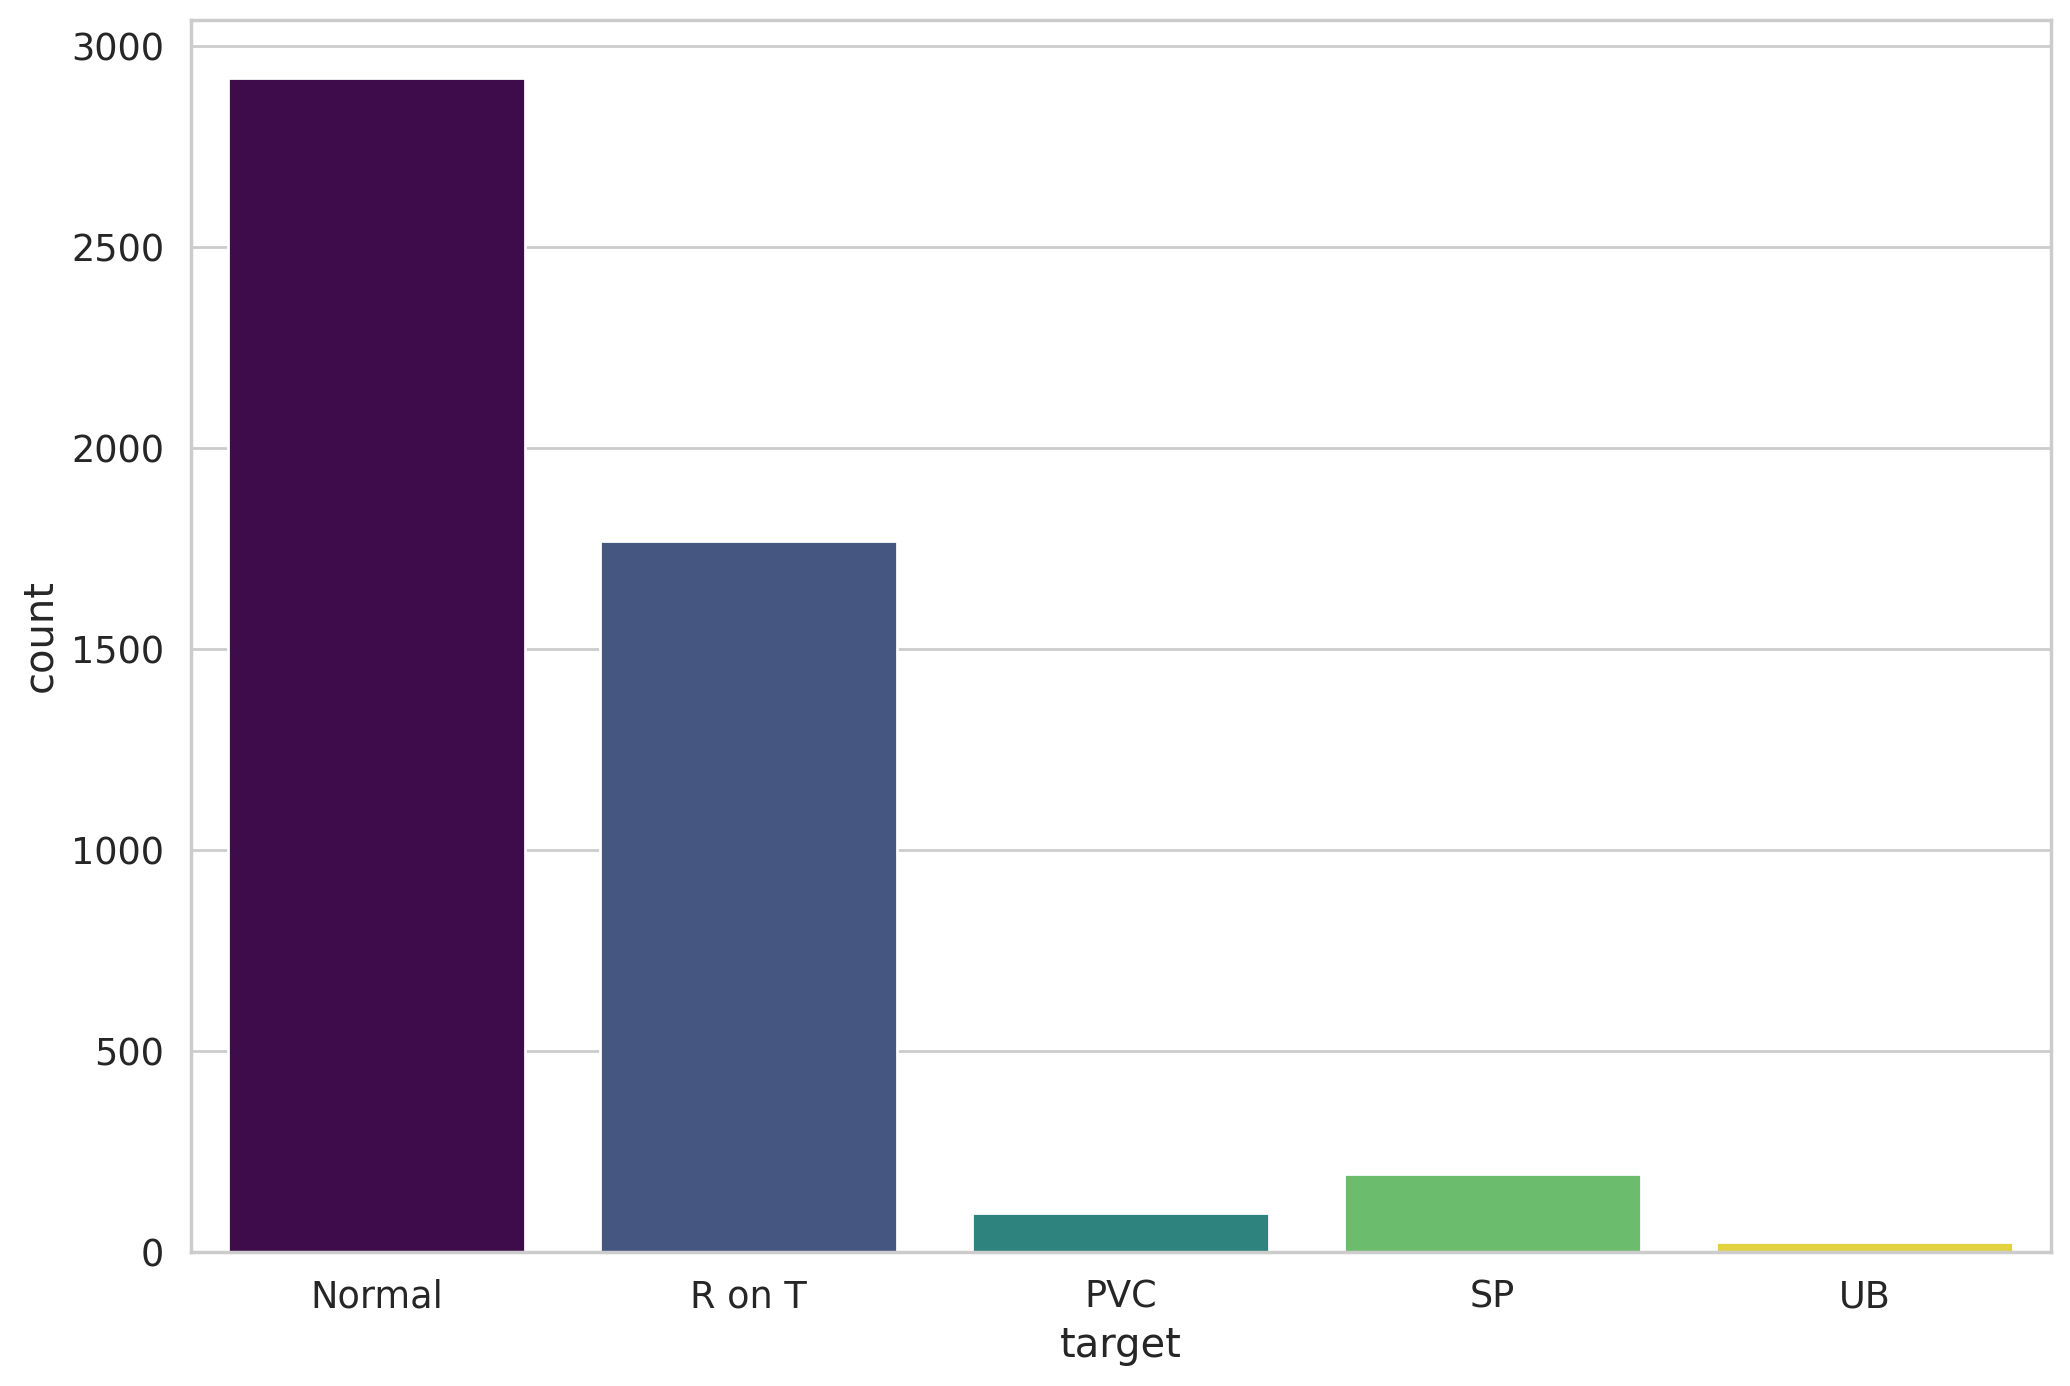

In [ ]:
ax = sns.countplot(x='target', data=df, hue='target', palette='viridis', legend=False)

ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names)

plt.show()

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Plotting an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

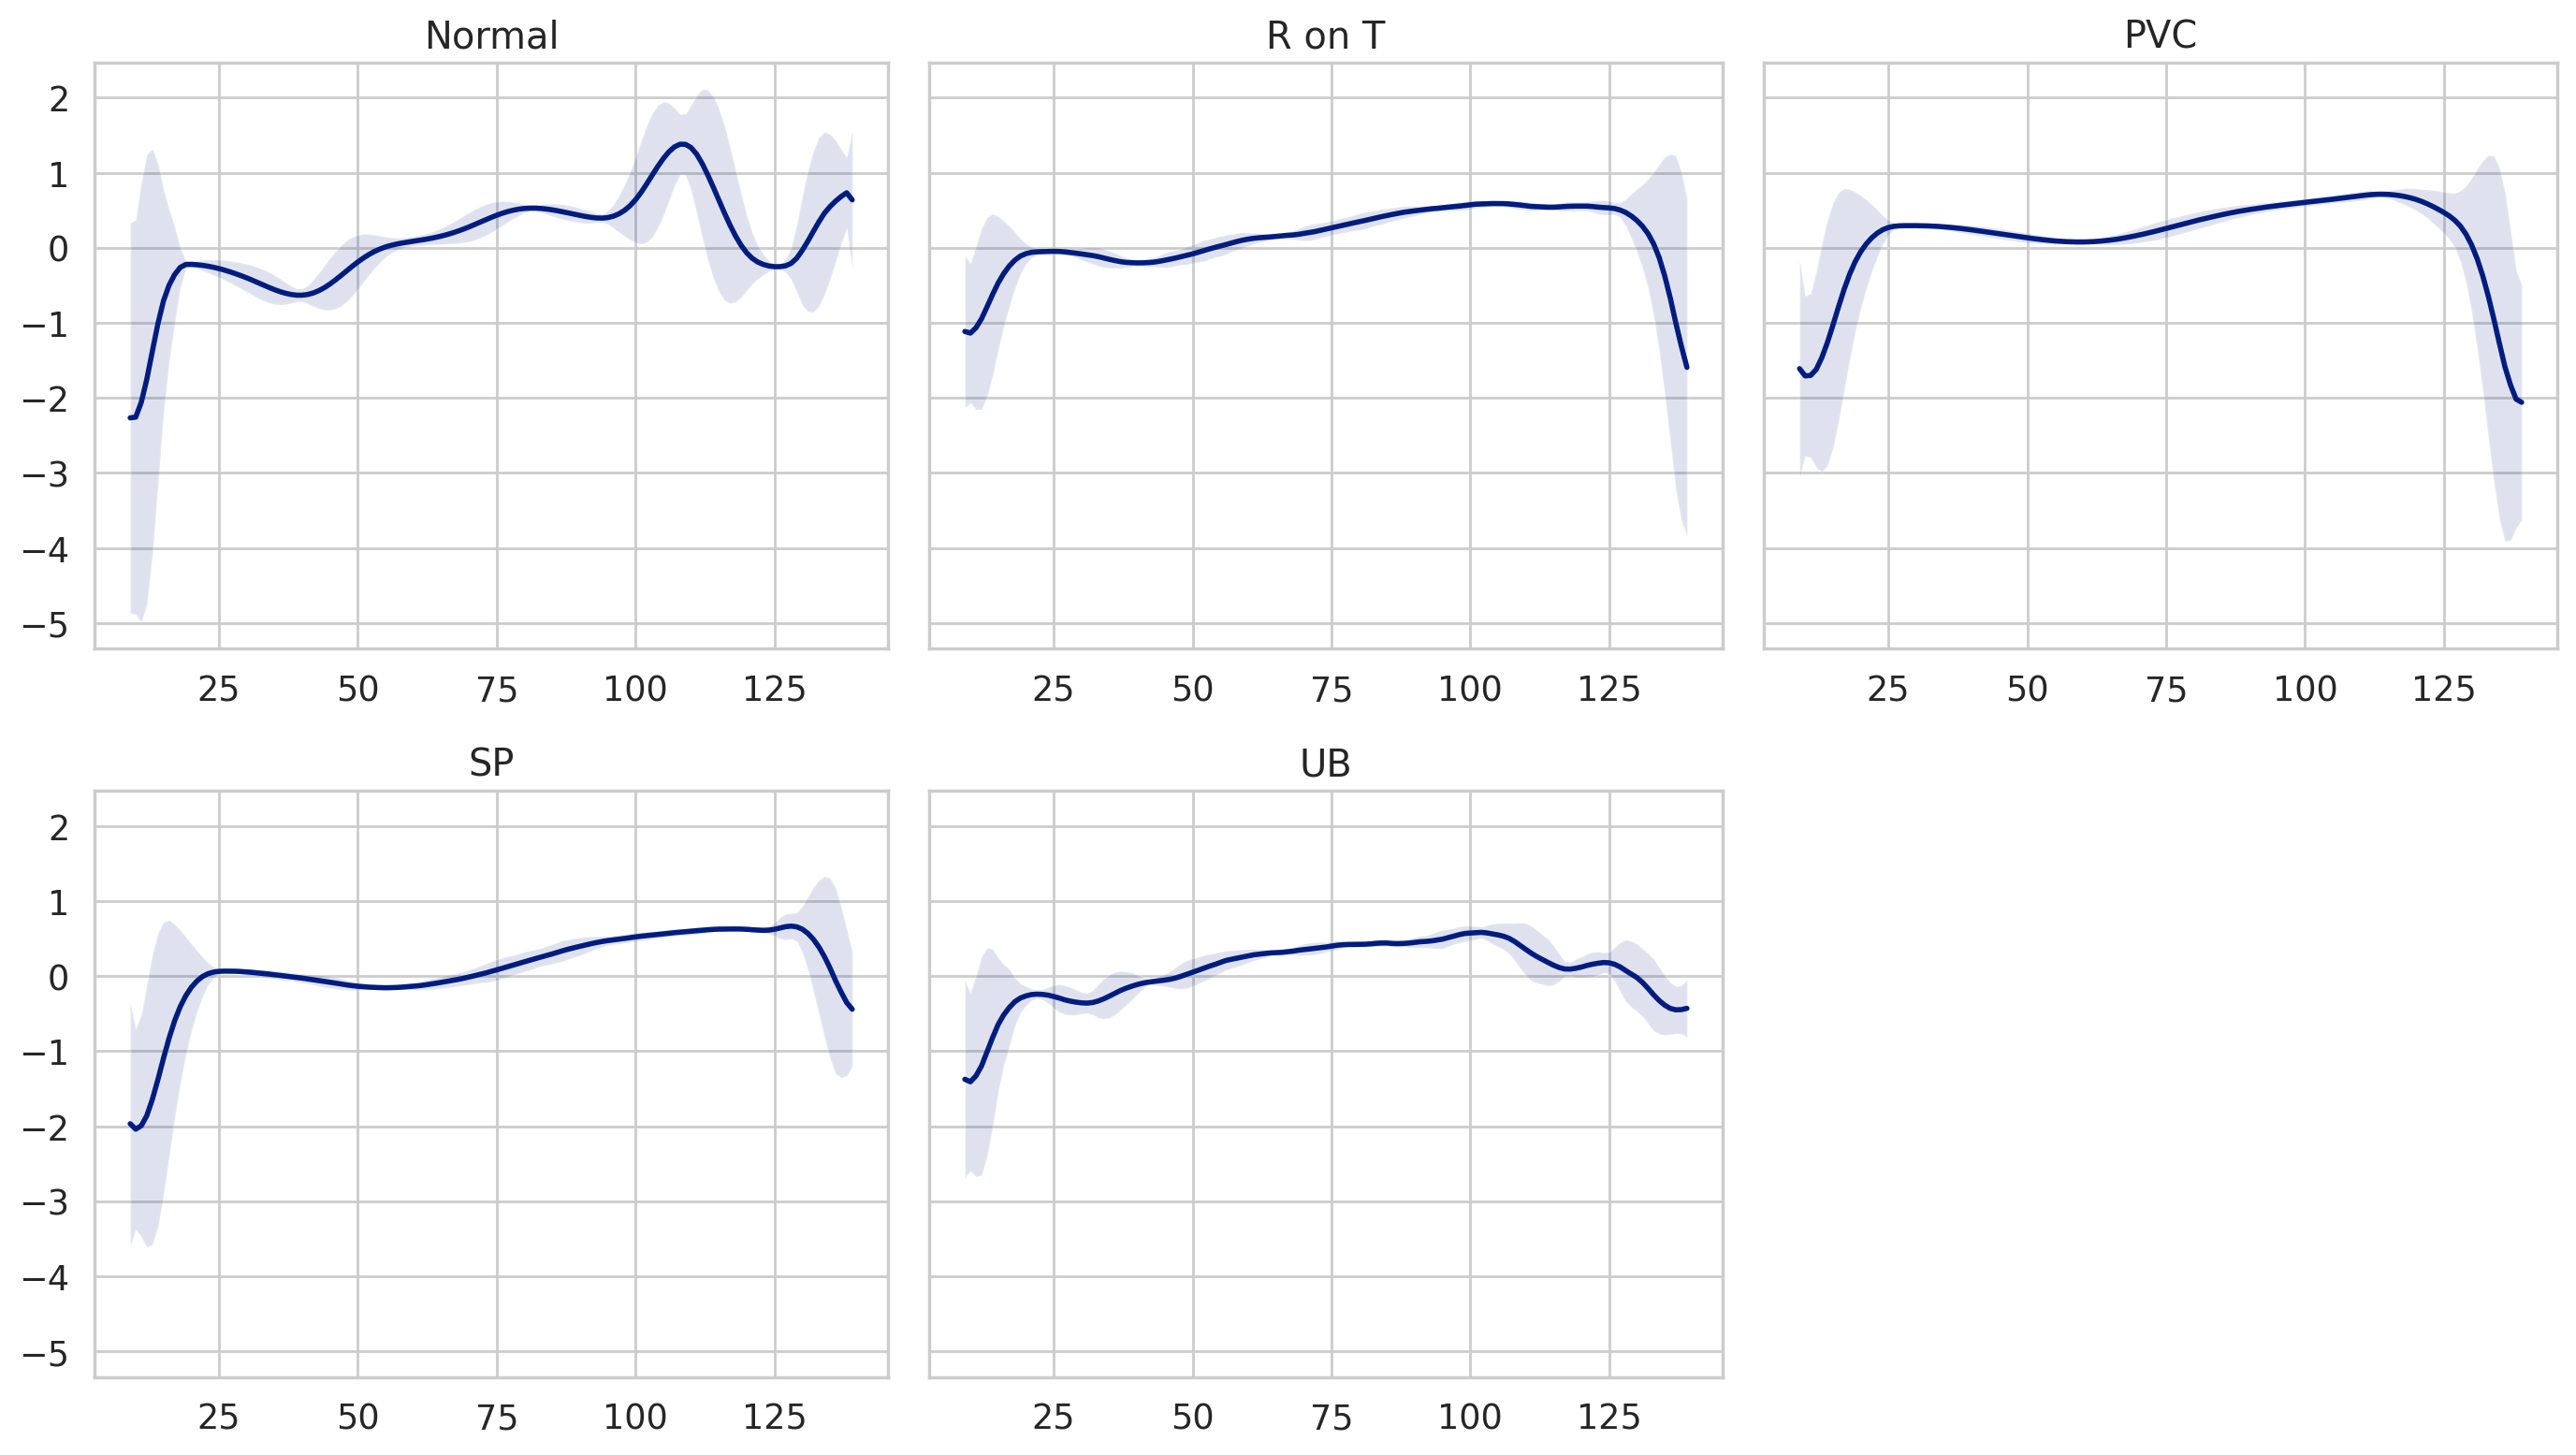

In [ ]:
sns.set_palette('dark')

classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = (
        df[df.target == cls]
        .drop(labels='target', axis=1)
        .mean(axis=0)
        .to_numpy()
    )
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()

Clearly the normal class has a distinctly different pattern than all other classes

## LSTM Autoencoder

An [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder) is a type of neural network designed to process input data, compress it through the model, and then reconstruct the original input as accurately as possible. The objective is to achieve this reconstruction with a minimal number of parameters, thereby learning a compressed representation of the data.

Autoencoders aim to extract and retain the most significant features of the data in this compressed form. In this context, we will examine how to apply an Autoencoder to Time Series data using Long Short-Term Memory (LSTM) layers. This approach, known as an LSTM Autoencoder, is particularly effective in capturing and modeling the temporal dependencies present in time series data.

To determine whether a sequence is normal or anomalous, we will set a threshold above which a heartbeat will be considered abnormal.

### Reconstruction Loss

The primary goal when training an Autoencoder is to minimize the reconstruction error between the input data and its reconstructed output. This is achieved by optimizing a loss function, commonly referred to as *reconstruction loss*. Examples of reconstruction loss functions include Cross-Entropy Loss and Mean Squared Error.


## Anomaly Detection in ECG Data

Normal heartbeats will be used as training data for our model and record the *reconstruction loss*.

## Preparing the data for LSTM Autoencoder model

Taking all the normal heartbeats and dropping the target (class) column

In [ ]:
normal_df = df[df.target ==(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

Merging all other classes and marking them as anomalies

In [ ]:
anomaly_df = df[df.target != (CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

Splitting the normal samples into train, validation and test sets

In [ ]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
val_df.shape

(219, 140)

In [ ]:
test_df.shape

(219, 140)

In [ ]:
train_df.shape

(2481, 140)

Writing a helper function to convert normal samples into tensors, so that it can be used to train the Autoencoder

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 for our Model).

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

## LSTM AutoEncoder

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history


In [ ]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 66.04732513812125 val loss 53.416068961086886
Epoch 2: train loss 52.779205385305765 val loss 60.30938727670608
Epoch 3: train loss 49.967706261311555 val loss 46.30222839634168
Epoch 4: train loss 39.10792704447293 val loss 37.483923559319486
Epoch 5: train loss 35.02392430557257 val loss 32.582817996473615
Epoch 6: train loss 32.028894622784286 val loss 31.149691250770605
Epoch 7: train loss 28.35933726547899 val loss 27.34841482171185
Epoch 8: train loss 26.678416552345677 val loss 24.96614168332592
Epoch 9: train loss 26.051449151829047 val loss 25.870393679022246
Epoch 10: train loss 25.21627584977863 val loss 22.942635340233373
Epoch 11: train loss 24.73415016810868 val loss 25.128260525394246
Epoch 12: train loss 24.611163433786842 val loss 26.026041335711195
Epoch 13: train loss 22.74400144390212 val loss 21.384333144584204
Epoch 14: train loss 21.140040373811797 val loss 21.91204628879077
Epoch 15: train loss 20.013450647544015 val loss 21.11564814336768
Ep

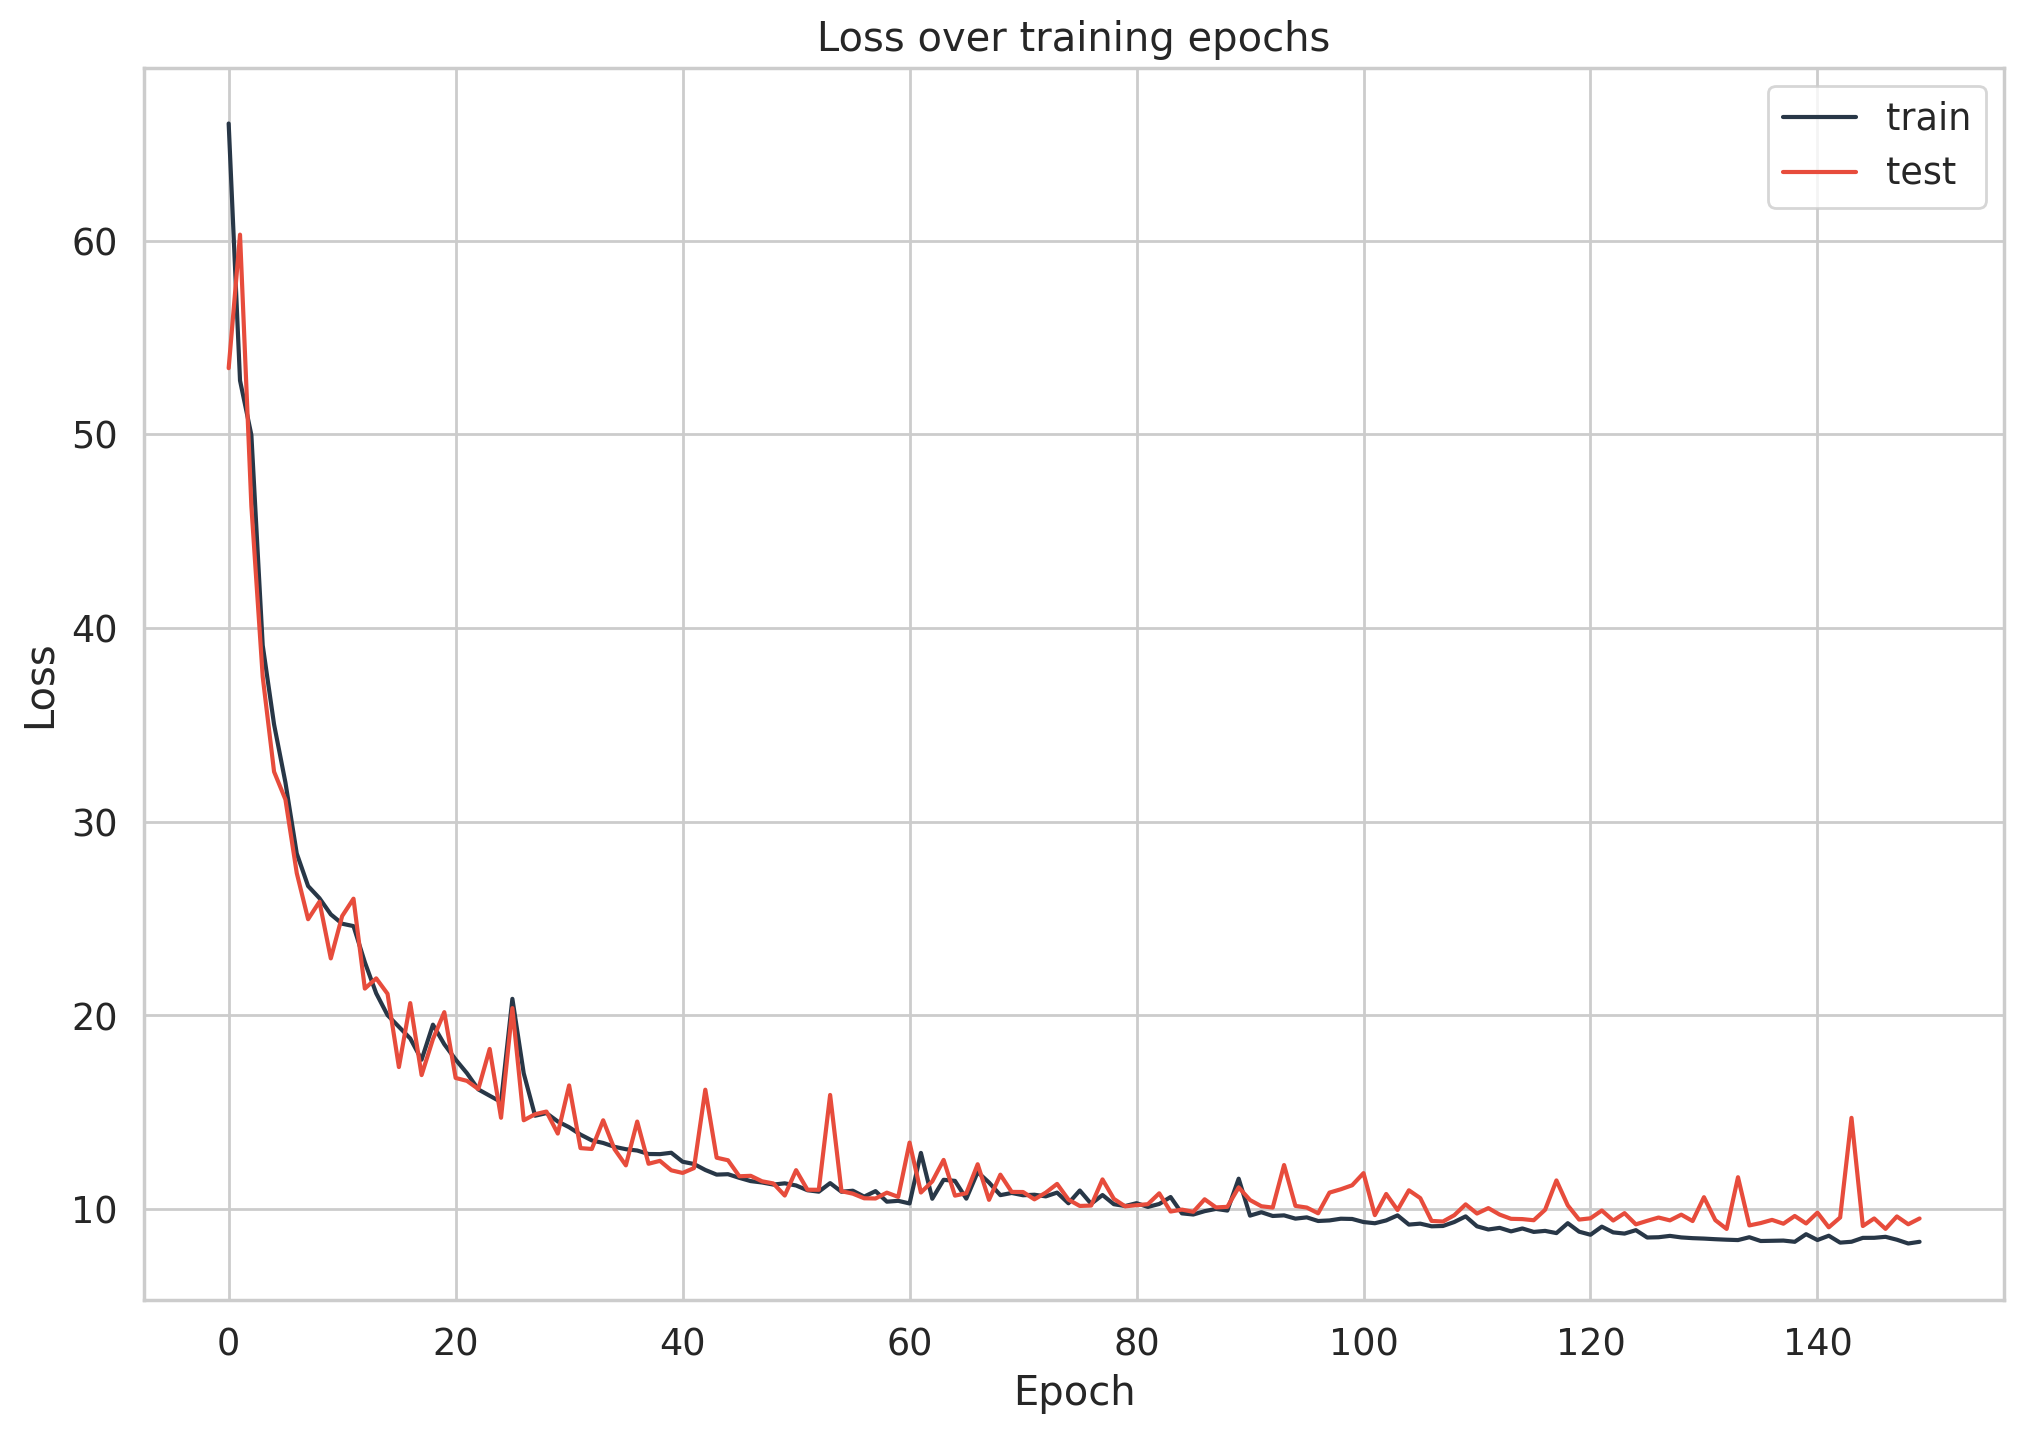

In [ ]:
COLORS = ["#283747", "#e74c3c"]

sns.set_palette(sns.color_palette(COLORS))

ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [ ]:
MODEL_PATH = 'ecg_model.pth'

torch.save(model, MODEL_PATH)

## Choosing a Threshold

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

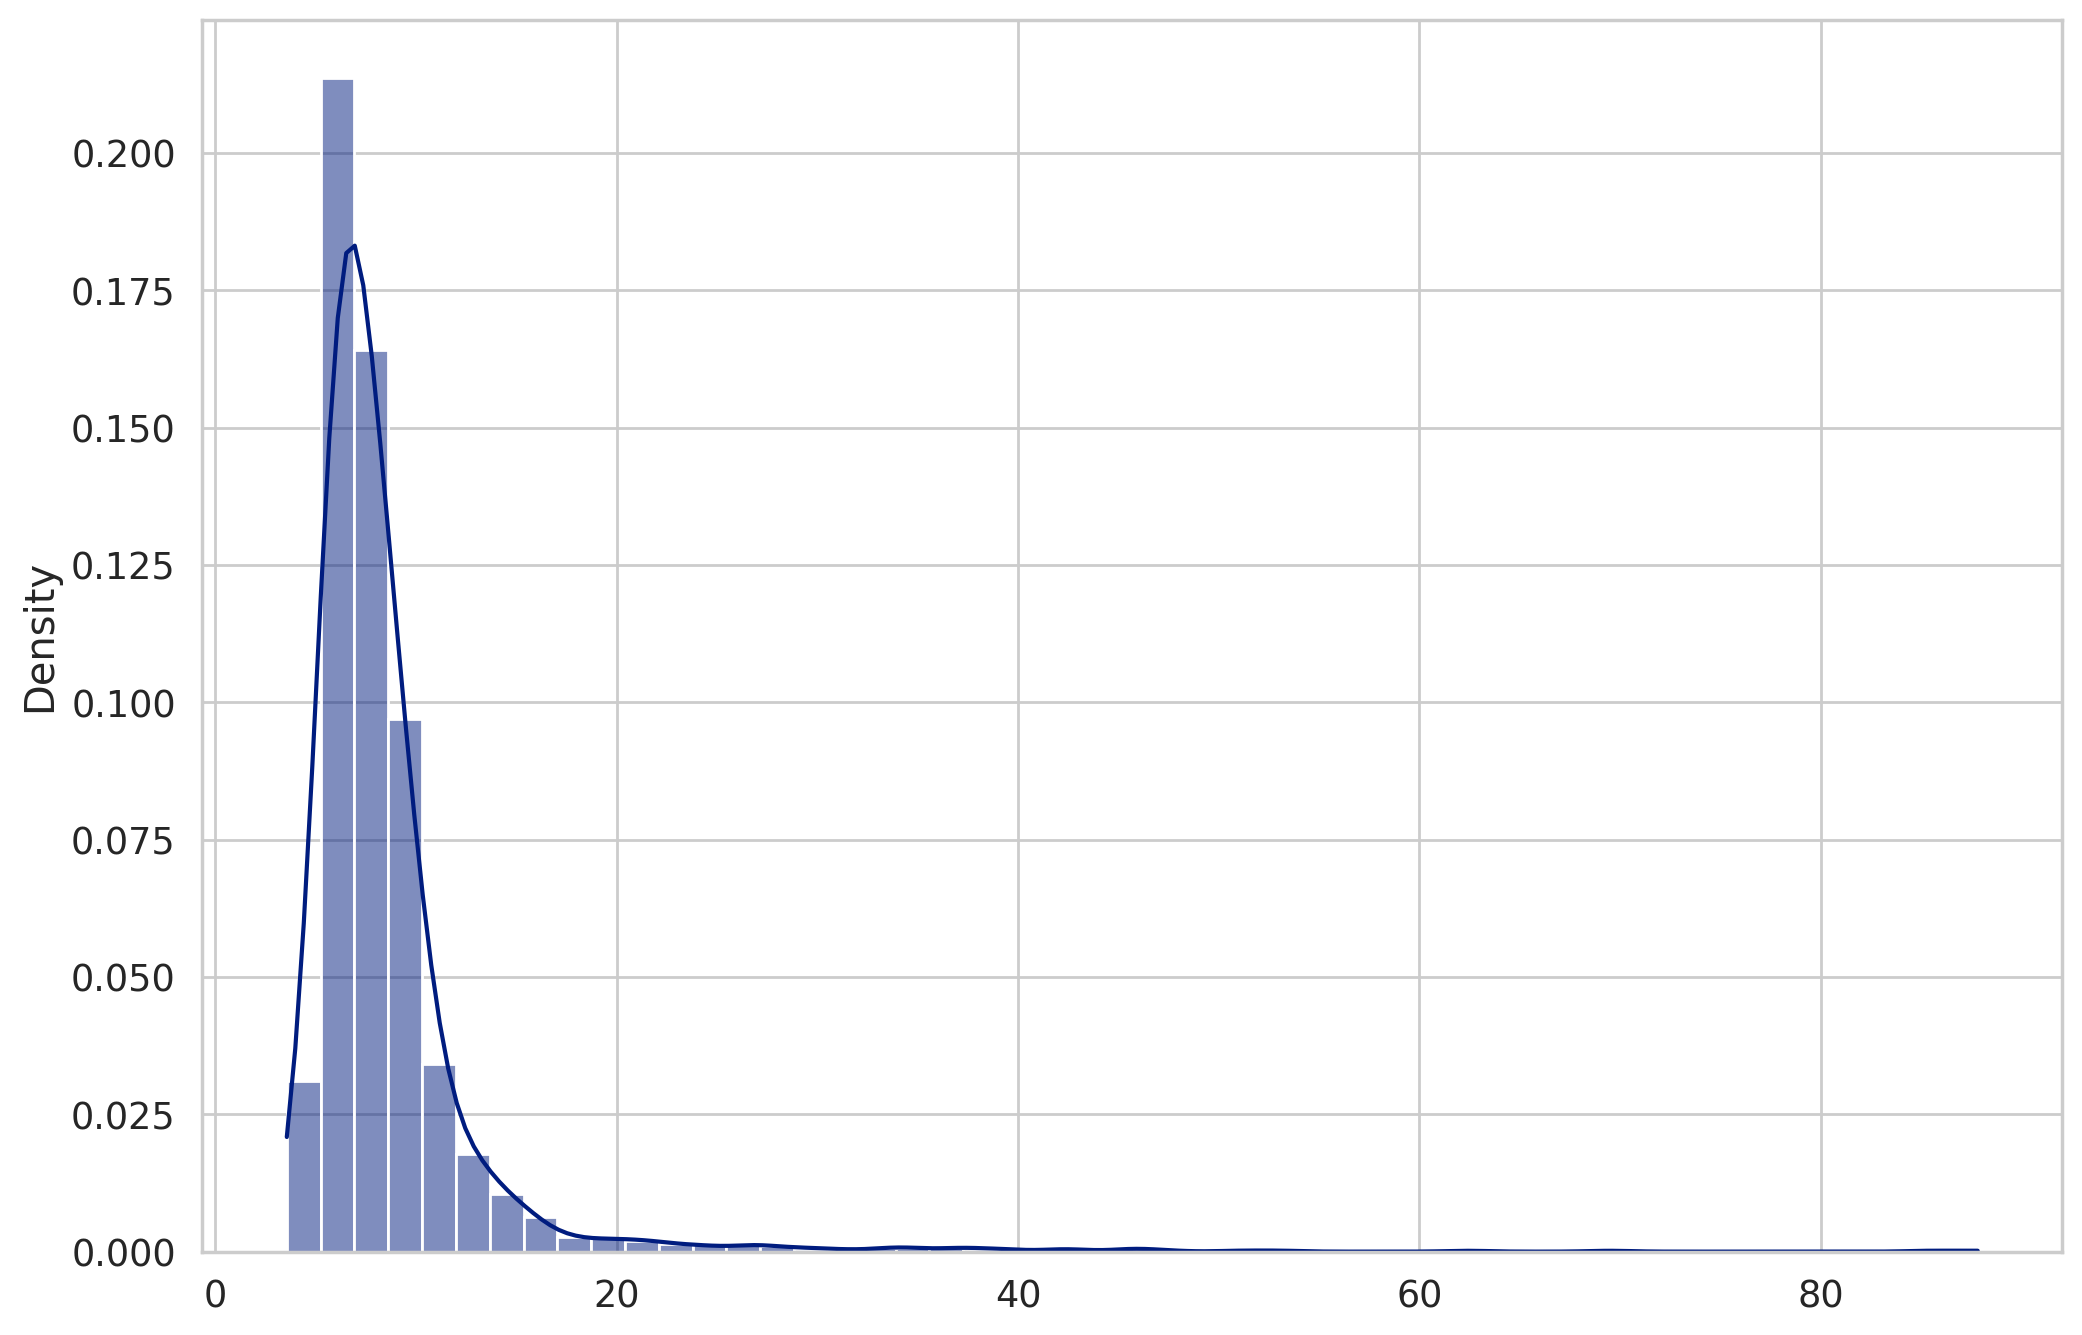

In [ ]:
_, losses = predict(model, train_dataset)
sns.set_palette('dark')
sns.histplot(losses, bins=50, kde=True, stat='density')
plt.show()

In [ ]:
THRESHOLD = 26

## Evaluation

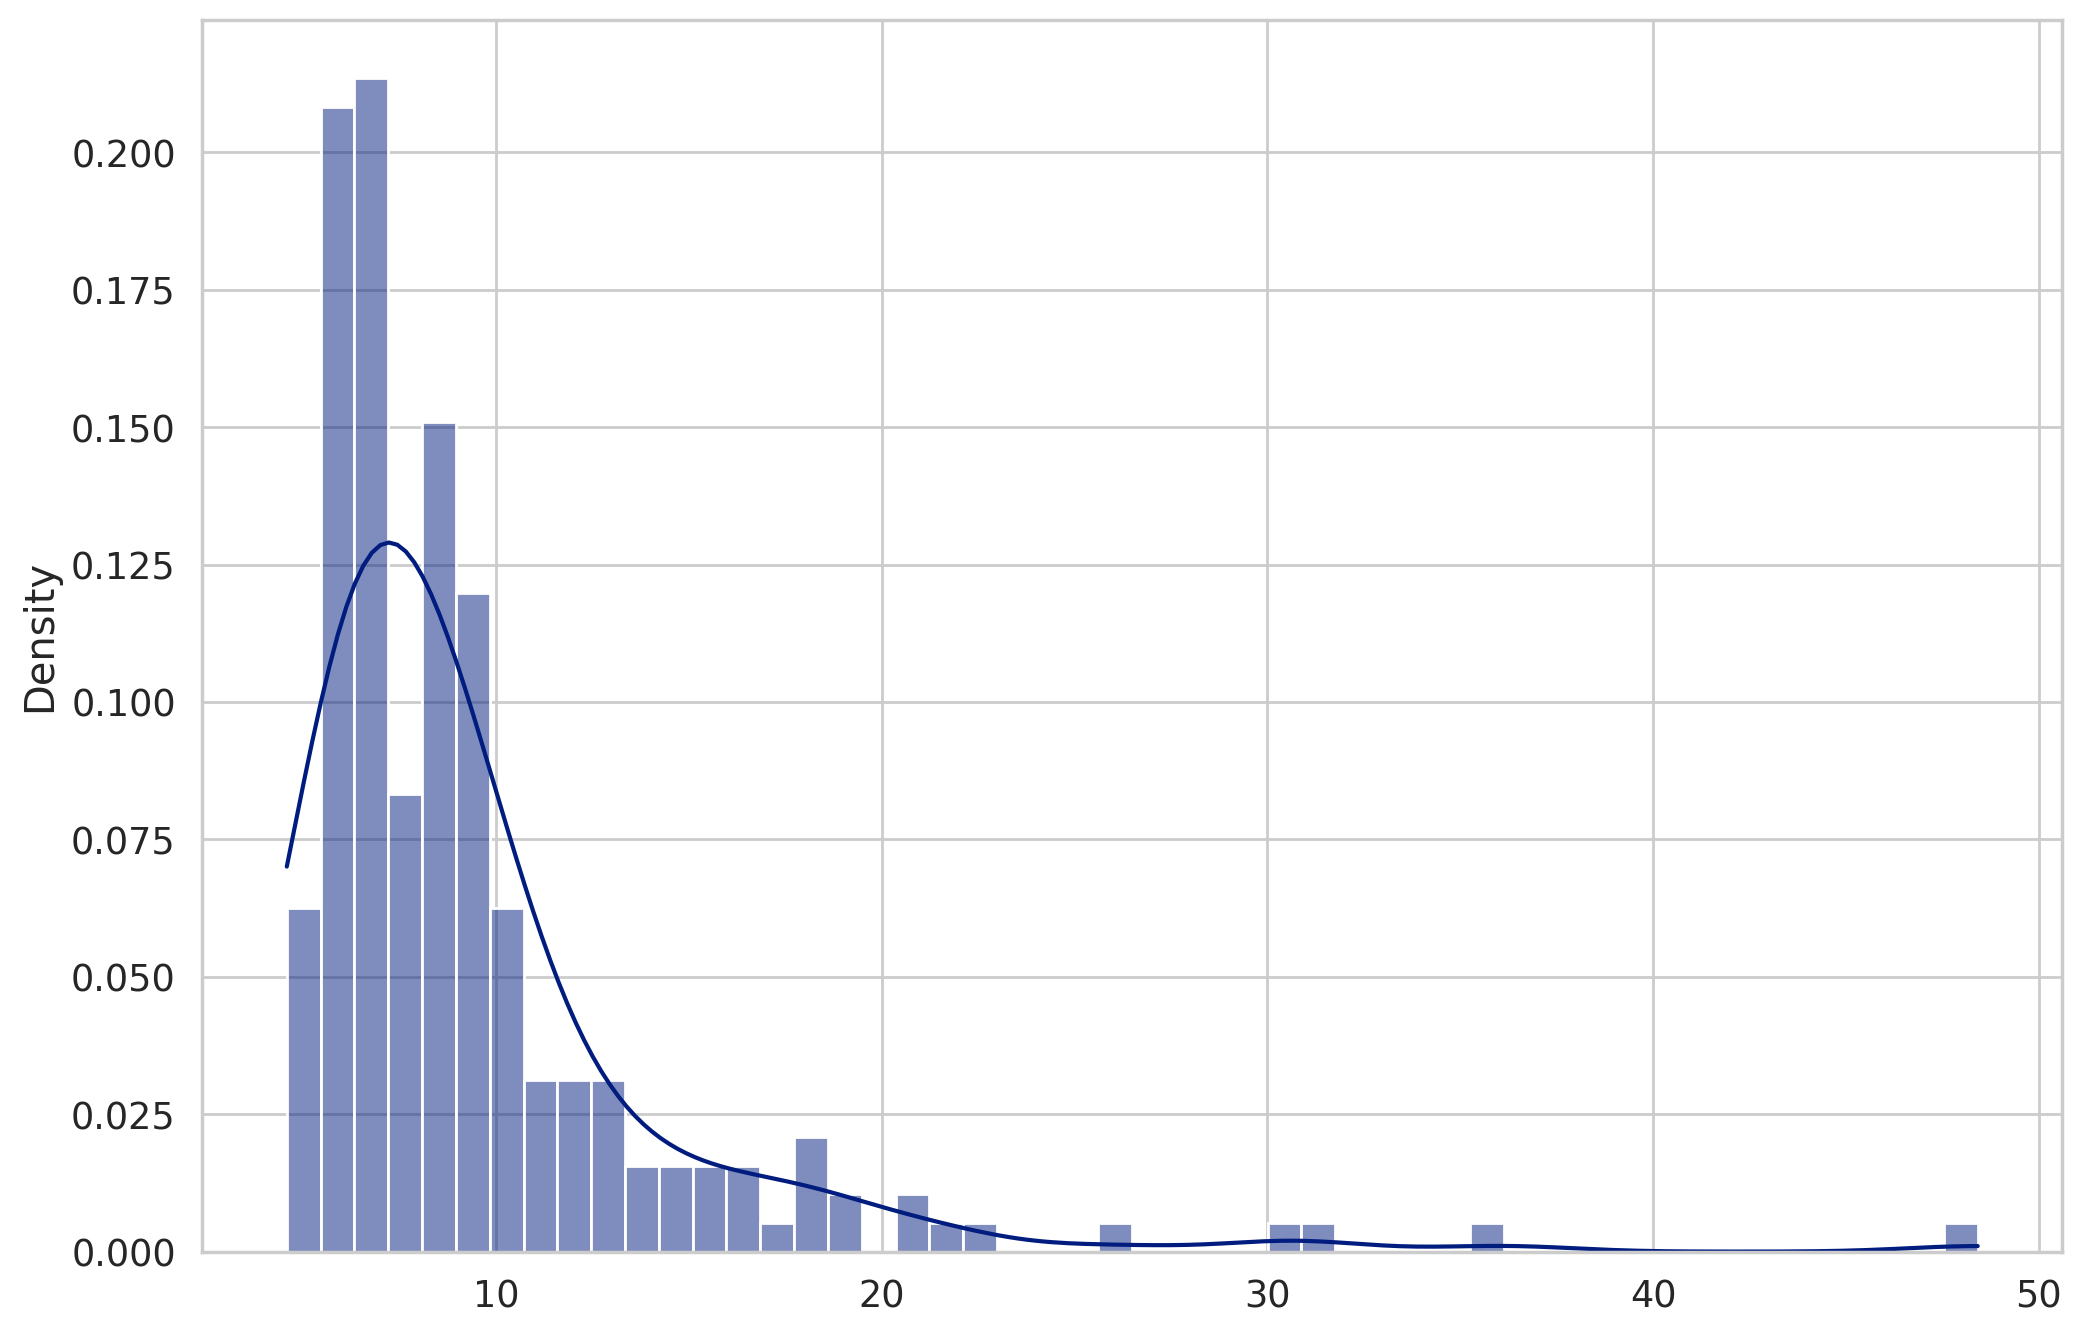

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.set_palette('dark')
sns.histplot(pred_losses, bins=50, kde=True, stat='density')
plt.show()

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 215/219


In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

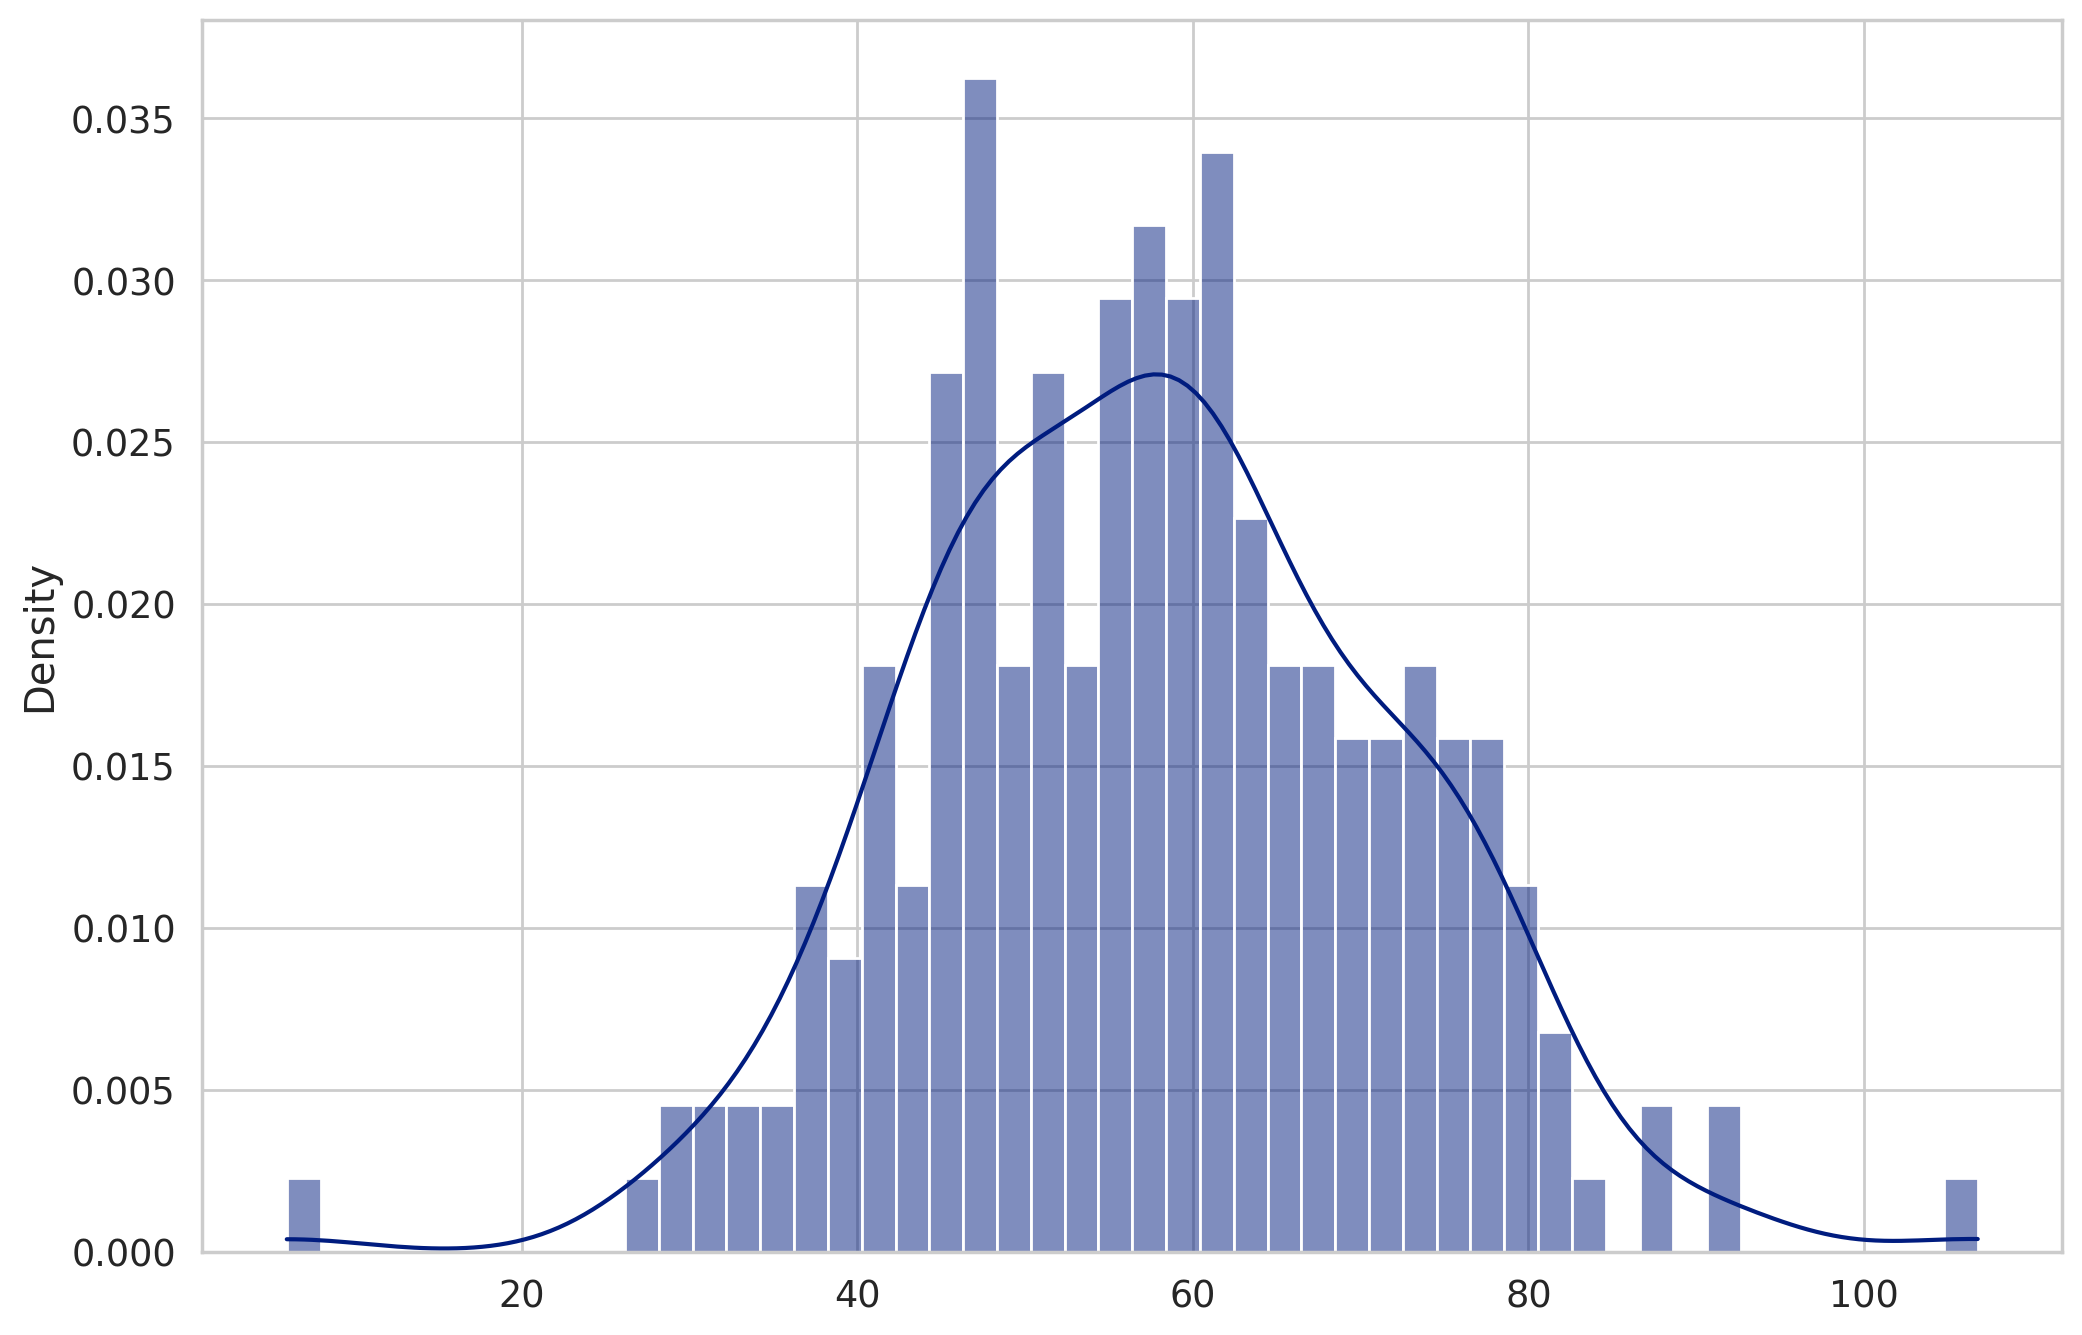

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.set_palette('dark')
sns.histplot(pred_losses, bins=50, kde=True, stat='density')
plt.show()

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 218/219


## Reconstructing and Computing loss for some samples

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

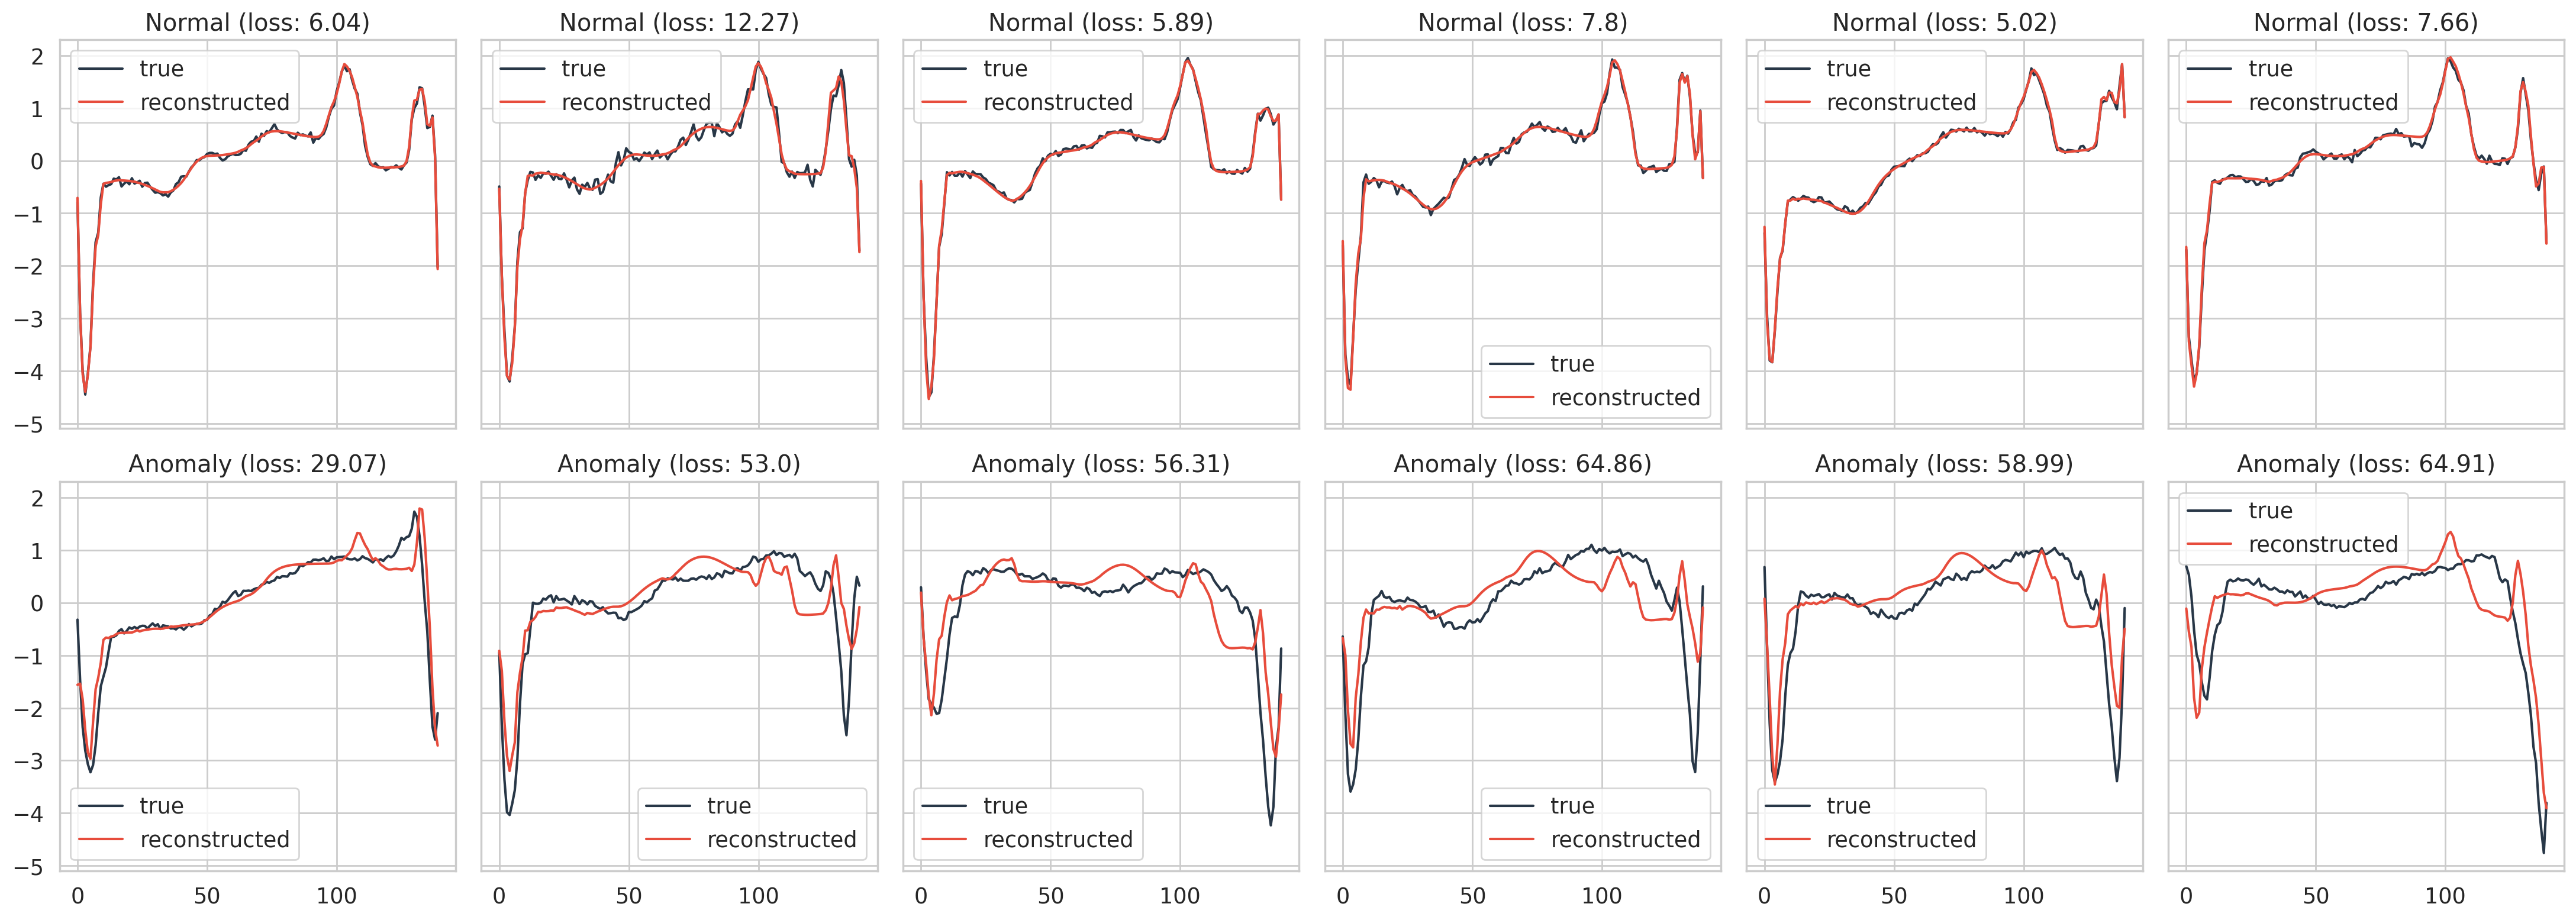

In [ ]:
COLORS = ["#283747", "#e74c3c"]

sns.set_palette(sns.color_palette(COLORS))
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();